In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
device = torch.device("cpu")

In [3]:
!ls

2classes		Alexnet_2bottle.ipynb		requirements.txt
4blackclasses_unbiased	Alexnet_2classes.ipynb		test
4classes		Alexnet_4bottle.ipynb
811differnet		Alexnet_4bottle_unbiased.ipynb


In [4]:
!ls 4blackclasses_unbiased

train  val


In [5]:
!ls 4blackclasses_unbiased/train

black  blacktumbler  silver  white


In [6]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ]) # try jittervalue 1


transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

training_dataset = datasets.ImageFolder('4blackclasses_unbiased/train', transform = transform_train)
validation_dataset = datasets.ImageFolder('4blackclasses_unbiased/val', transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [7]:
print("train_len:", len(training_dataset))
print("val_len:", len(validation_dataset))

train_len: 98
val_len: 29


In [8]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [9]:
classes = ['black', 'blacktumbler', 'silver', 'white']

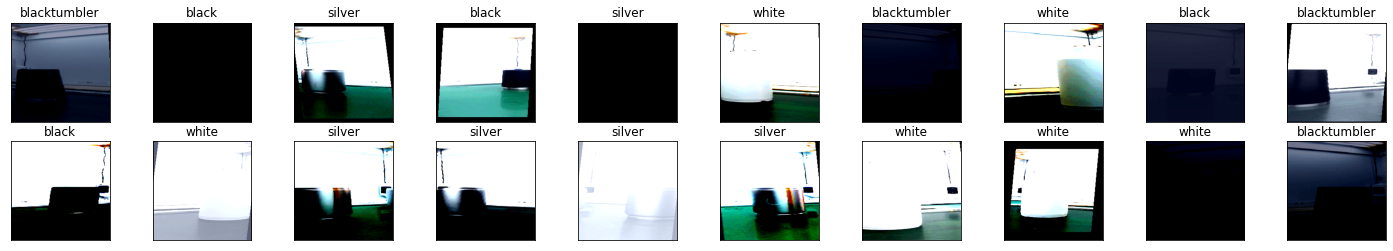

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [11]:
model = models.alexnet(pretrained=True)

In [12]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
for param in model.features.parameters():
  param.requires_grad = False

In [14]:
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

4


In [15]:
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [17]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 0.0646, acc0.4184
validation loss: 0.0439, validation acc0.7586
epoch: 2
training loss: 0.0469, acc0.6633
validation loss: 0.0269, validation acc0.7931
epoch: 3
training loss: 0.0326, acc0.8265
validation loss: 0.0259, validation acc0.7931
epoch: 4
training loss: 0.0313, acc0.7551
validation loss: 0.0220, validation acc0.7586
epoch: 5
training loss: 0.0278, acc0.8061
validation loss: 0.0157, validation acc0.8966
epoch: 6
training loss: 0.0234, acc0.8367
validation loss: 0.0213, validation acc0.8621
epoch: 7
training loss: 0.0202, acc0.8571
validation loss: 0.0168, validation acc0.8621
epoch: 8
training loss: 0.0169, acc0.9184
validation loss: 0.0224, validation acc0.8621
epoch: 9
training loss: 0.0256, acc0.7857
validation loss: 0.0182, validation acc0.8966
epoch: 10
training loss: 0.0132, acc0.8980
validation loss: 0.0192, validation acc0.8621


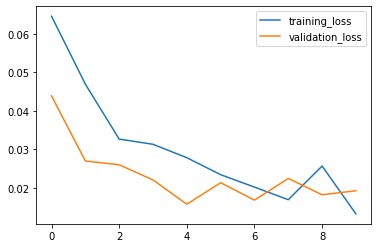

In [18]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(val_running_loss_history, label = "validation_loss")
plt.legend()

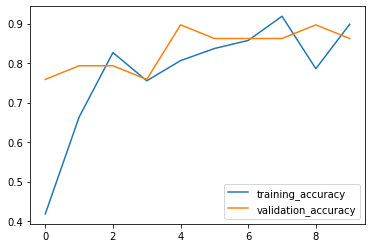

In [19]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(val_running_corrects_history, label = "validation_accuracy")
plt.legend()

In [21]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
    Running setup.py install for pillow ... done
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matplotlib 3.5.0 requires pillow>=6.2.0, but you'll have pillow 5.2.0 which is incompatible.
You should consider upgrading via the '/home/lihang/chenggui/811test/.env/bin/python3.8 -m pip install --upgrade pip' command.


In [20]:
import PIL.ImageOps

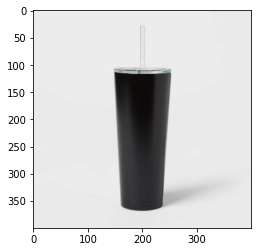

In [21]:
import requests
from PIL import Image

# test an blacktumbler bottle
img1 = Image.open(r'test/1.jpg')
plt.imshow(img1)

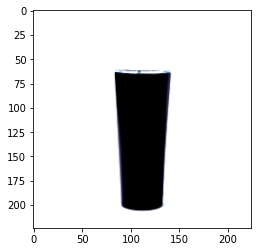

In [22]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [23]:
# Check the predicted type of blacktumbler bottle
image1 = img1.to(device).unsqueeze(0)
output = model(image1)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: Blacktumbler')

Predicted Class: silver
Actual Class: Blacktumbler


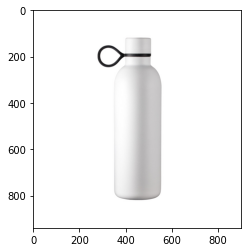

In [24]:
import requests
from PIL import Image

img2 = Image.open(r'test/3.jpg')
plt.imshow(img2)

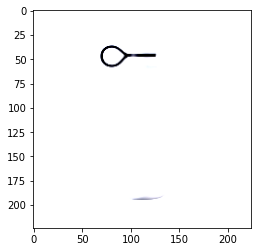

In [25]:
img2 = transform(img2)
plt.imshow(im_convert(img2))

In [26]:
image2 = img2.to(device).unsqueeze(0)
output = model(image2)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: white')

Predicted Class: silver
Actual Class: white


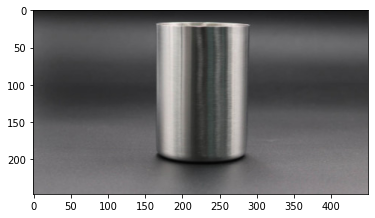

In [27]:
import requests
from PIL import Image

img3 = Image.open(r'test/2.jpg')
plt.imshow(img3)

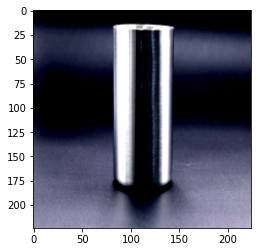

In [28]:
img3 = transform(img3)
plt.imshow(im_convert(img3))

In [29]:
image3 = img3.to(device).unsqueeze(0)
output = model(image3)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: silver')

Predicted Class: silver
Actual Class: silver


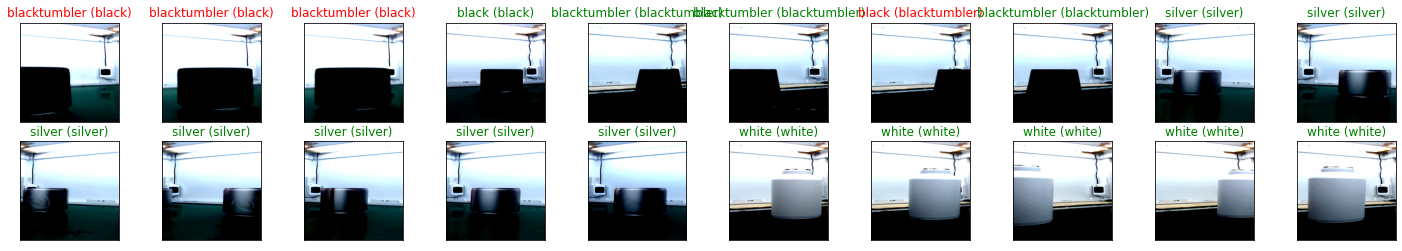

In [30]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
lables = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))

### Accredit
Alexnet Implementation code of this notebook is based on the source code of the udemy online course "PyTorch for Deep Learning and Computer Vision" by Rayan Slim, Jad Slim, Amer Sharaf, Sarmad Tanveer.